Scheutjens-Fleer Self-Consistent Field
======================================

We employ a two-gradient SF-SCF method in cylindrical geometry. A full description is given in Supplementary Note 3 of the original work. Here we provide technical details sufficient for reproducibility.

We do not cover input-file generation in detail (this is well documented in the Namics/SFbox manual), but we include a minimal example below.

# Computing polymer density profiles in the absence of colloid particle

## Defining the system for SF-SCF
Each grafted chain is anchored by a monomer segment pinned to the pore wall. Pinned segments are constrained to the inner cylindrical surface (constant radius) and can translate along the $z$-axis (one fewer degree of freedom than a free segment). 
To prevent this lateral motion, the pore is partitioned into discrete slices (rings) along $z$; each slice defines its own grafting site, immobilizing pinned segments within that slice. For every slice, a fraction of chains is grafted so that the total polymer amount is evenly distributed along the pore and the grafting density is conserved.

Example input snippet from `SCF/empty_pore_input.in`:

```text
mol:pol0:composition:(P0)1(P)299
mol:pol0:freedom:restricted
mol:pol0:theta:980.1769079200155
mon:P0:freedom:pinned
mon:P0:pinned_range:26,121;26,121
...
mol:pol51:composition:(P0)1(P)299
mol:pol51:freedom:restricted
mol:pol51:theta:980.1769079200155
mon:P51:freedom:pinned
mon:P51:pinned_range:26,172;26,172
```

## Reading the output

The numerical SF-SCF algorithm minimizes the excess Helmholtz free energy subject to incompressibility, yielding the equilibrium polymer volume-fraction field originating from each grafting slice. In our system, the pore length is 52 lattice units with slices labeled $z=−26, \ldots ,+25$. Each slice corresponds to one set of grafted chains, allowing us to resolve how grafting position contributes to the overall distribution. Namics/SFbox output files provide local volume fractions $\phi_n(r, z)$ (and per-origin contributions) on the cylindrical lattice.

### Extracting polymer density profile

Internally, Namics/SFbox first computes the polymer density per segment. Summing over all segments of a given chain yields the density for that chain (i.e. the molecular species corresponding to one grafting slice). Because in this grafting scheme we effectively have 52 ($L=52$) species (one for each slice along $z$), the full polymer brush density is obtained by summing across all species:

$$
\phi_n(r,z) = \sum_{s=1}^{N} \phi_{s,n}(r,z)
$$
$$
\phi(r,z) = \sum_{n=1}^{L} \phi_n(r,z)
$$

where  
- $s$ indexes chain segment ($s = 1, \dots, N$),
- $n$ indexes chain segment ($n = 1, \dots, L$), 
- $\phi_{s,n}(r,z)$ s the contribution of segment $s$ from chains grafted at slice $n$,  
- $\phi(r,z)$ is the total volume fraction.  


The code below loads these results, and plots the **Contributions to polymer volume fraction profiles**  with an interactive slider to select grafting site.  

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, clear_output

from src.read_namics_output import (
    extract_volume_fractions_per_grafting_range,
    create_walls,
    build_scf_empty_pore_results,
)
from src.utils import mirror_extend
from src.make_plot import plot_with_slider, plot_grid

# ------------------------------------------------------------
# Load SCF-SCF results for an unperturbed pore
# In this showcase, we use the "moderately poor" pore with χ_PS = 0.6
# ------------------------------------------------------------
SCF_empty_pore_result = build_scf_empty_pore_results(
    "SCF/output/empty_pore_input", chi_PS=0.6
)

R = SCF_empty_pore_result["R"]         # radial grid points
Z = SCF_empty_pore_result["Z"]         # axial grid points

# Polymer volume fraction contributions per grafting slice (list of 2D arrays)
phi_n = SCF_empty_pore_result["phi_n"]

# Total polymer density (sum over all slices)
phi_0 = SCF_empty_pore_result["phi"]

# If pore with colloid insertion is available, use its mask of impermeable cells
colloid_mask = SCF_empty_pore_result.get(
    "colloid_mask", np.zeros_like(phi_n[0])
)

# ------------------------------------------------------------
# Create mask for pore walls (impermeable region)
# ------------------------------------------------------------
pore_radius = 26
pore_length = 52
walls = create_walls(len(R), len(Z), pore_radius, pore_length)

## Plotting the results
An interactive **slider** is provided to scroll along the pore axis $z$, allowing visualization of how chains grafted at different axial positions contribute to the density distribution inside the pore.

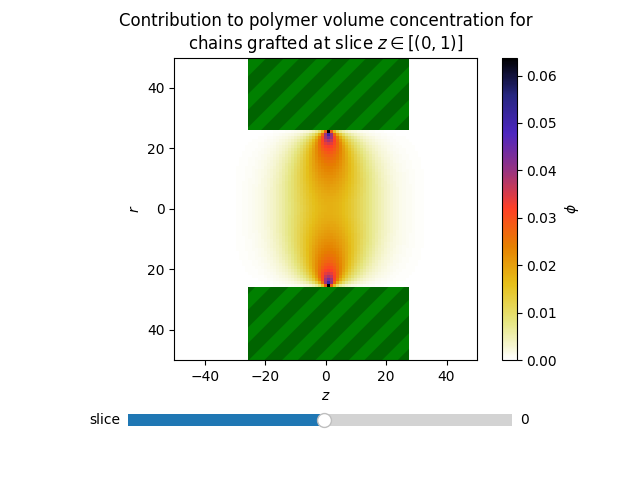

In [2]:
# ------------------------------------------------------------
# Interactive plot: contributions from individual grafting slices
# ------------------------------------------------------------
fig, ax = plot_with_slider(
    Z,
    R,
    phi_n,
    fix_clim=True,
    walls=walls + colloid_mask,
    rlim=(-50, 50),
    zlim=(-50, 50),
)

## Unperturbed polymer density profile

We now plot the **total polymer volume fraction** \(\phi(r,z)\), obtained by summing the contributions of all chains grafted along the pore.

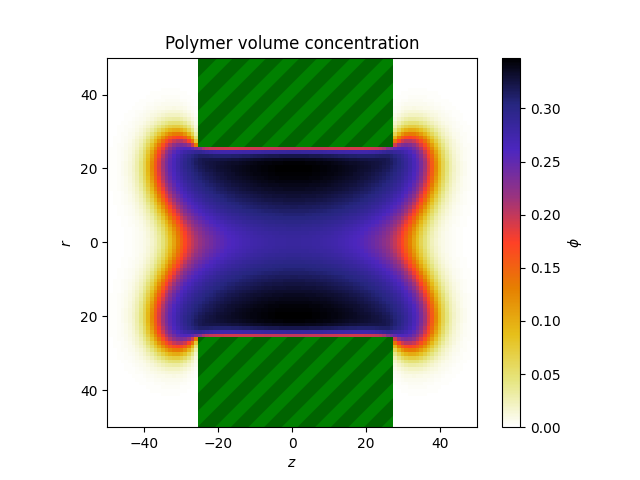

In [3]:
# ------------------------------------------------------------
# Plots unperturbed polymer density profile
# ------------------------------------------------------------
fig, ax = plot_grid(
    Z, 
    R, 
    phi_0, 
    walls = walls + colloid_mask,
    rlim = (-50,50),
    zlim = (-50,50)
)


## Colloid traversing the pore: polymer density profiles and insertion free energy

Minor modifications to the input files allow us to model the insertion of a **cylindrical colloid particle** into the pore and, subsequently, its traversal along the central axis.  
The key changes are introduced in `SCF/colloid_traversing_pore.in`.

```text
mon:P:chi_C:0.0
mon:C:freedom:frozen
mon:C:frozen_range:1,18;3,23
...
start
mon:C:frozen_range:1,64;3,69
start
mon:C:frozen_range:1,65;3,70
start
mon:C:frozen_range:1,66;3,71
...
```

Here, the *frozen range* specifies lattice cells that are impermeable to the polymer, thereby representing the colloid.  
Sequential calculations with a rolling frozen range correspond to the particle moving stepwise along the pore axis.

In this example we model an **inert colloid**, with polymer-colloid interaction parameter $\chi_{\text{PC}} = 0$.  
We skip explicit summation over $\phi_n$ and instead use the **total polymer volume fraction** $\phi$.

### Reading the output

For each colloid position we collect:
- **Scalar quantities** such as the system free energy \(F_{\text{SF-SCF}}\). These are appended to `output/prefix.kal` during sequential calculations.
- **Density profiles** perturbed by the colloid. These are written to separate files `output/prefix_[idx].pro`, with `idx` incrementing from 1.
 
In `build_scf_results`, the **ground-state correction** for the insertion free energy is applied:

$$
\Delta F_{\text{SF-SCF}}(z_c) 
= F_{\text{SF-SCF}}(z_c) - F_{\text{SF-SCF}}(z_c^{\text{bulk}}),
$$

where $z_c^{\text{bulk}}$ is a reference position far from the pore.

The code below reads all output files and organizes them into an indexable `pandas` table. 


In [4]:
from src.read_namics_output import build_scf_results

# Parameters for this example calculation
input_parameters_for_SCF = {
    "colloid_diameter": 6,
    # 82 positions in total; [-126] is chosen for ground-state correction
    "colloid_positions": [-126] + list(range(-80, 1, 1)),
    "chi_PS": 0.6,
    "chi_PC": 0.0,
}

# Collect results into a pandas DataFrame
SCF_results = build_scf_results(
    "SCF/output/colloid_traversing_pore",
    **input_parameters_for_SCF,
    verbose=True,
)

clear_output()
display(SCF_results)

,colloid_position,free_energy,R,Z,colloid_mask,phi,chi_PS,chi_PC,colloid_diameter
0,-126,0.000000e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.807248975536214e-36, 4.810278853221177e-36...",0.6,0.0,6
1,-80,4.254362e-07,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3824091847953278e-36, 6.499113029499542e-3...",0.6,0.0,6
2,-79,-1.070552e-06,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3844317397246058e-36, 6.504955308354355e-3...",0.6,0.0,6
3,-78,-1.216409e-06,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.386297029449025e-36, 6.510346675233576e-36...",0.6,0.0,6
4,-77,-6.565788e-07,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3880129751339455e-36, 6.515309720142424e-3...",0.6,0.0,6
...,...,...,...,...,...,...,...,...,...
77,-4,3.942414e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.421881700488103e-36, 6.610459377024275e-36...",0.6,0.0,6
78,-3,3.957194e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.4212838463175475e-36, 6.608825292455871e-3...",0.6,0.0,6
79,-2,3.967683e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.420703132596997e-36, 6.60723808280798e-36,...",0.6,0.0,6
80,-1,3.974013e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.420138458861941e-36, 6.605694738217534e-36...",0.6,0.0,6


### Plotting the results. Colloid particle disturbs local polymer density

As whe chose $\chi_{\text{PC}} = 0$ which corresponds to inert colloid, one can see depleted region forming around the particle
The figure below provides intercative view, use slider to control colloid position.
Note the insertion free energy in the lower right box, it is always positive
We keep other parameters fixed as in Figure 1 of the original work, $\chi_{\text{PS}} = 0.6$ and $d = 6$

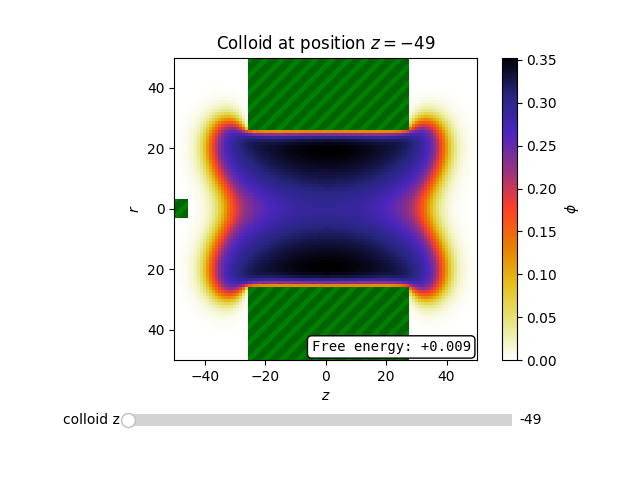

In [8]:
# --------------------------------------------------------------------------------
# Interactive plot: perturbed polymer concentration upon advancing colloid postion
# --------------------------------------------------------------------------------
from src.make_plot import plot_phi_with_colloid_slider
fig = plot_phi_with_colloid_slider(
    SCF_results, 
    fix_clim=True,
    walls=walls,     
    rlim = (-50,50),
    zlim = (-50,50)
    )

### Plotting the results: insertion free energy vs. colloid position

The central result of this exercise is the **insertion free energy profile**  
$$
\Delta F_{\text{SF-SCF}}(z_c) \;=\; \Delta F_{\text{SF-SCF}}(\chi_{\text{PS}}, \chi_{\text{PC}}, d, z_c),
$$
evaluated for the selected case $\chi_{\text{PC}} = 0$, $\chi_{\text{PS}} = 0.6$, and colloid diameter $d = 6$.

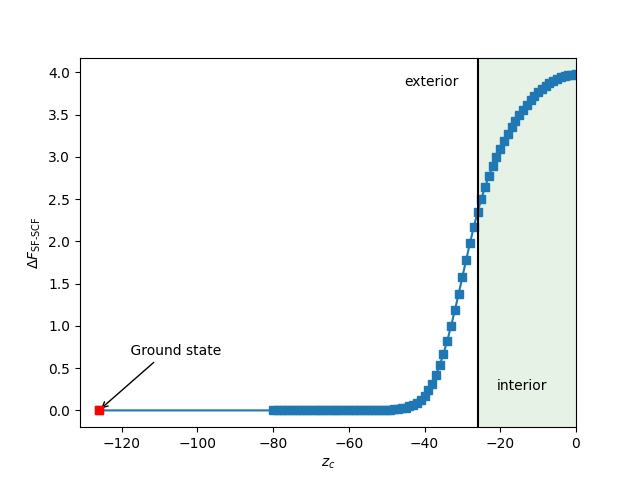

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from src.make_plot import plot_insertion_free_energy

fig, ax = plot_insertion_free_energy(SCF_results, pore_length=52, show_ground_state=True)


# Analytical estimation of insertion free energy for cylindrical colloids

The two-gradient SF-SCF method yields the position-dependent insertion free energy $\Delta F_{\text{SF-SCF}}(z_c)$ for a cylindrical colloid constrained coaxially along the $z$-axis, as described in the original work.

An analytical approach extends to arbitrarily positioned colloids. The osmotic term follows from the polymer volume fraction via a mean-field Flory expression, while the interfacial term includes entropic (confinement) and enthalpic (polymer-colloid, $\chi_{\text{ads}}$) contributions; at $\chi_{\text{ads}}=\chi_{\text{ads}}^{\text{crit}}$ the interfacial term vanishes. Local polymer perturbations near the surface are captured by two phenomenological parameters $b_0$ and $b_1$.

## Fitting b0 and b1 to match analytical model to SF-SCF data
For a coaxial cylinder, both methods apply, enabling a direct fit. We determine $b_0$ and $b_1$ by minimizing 
$$
\sum_{\text{parameters}}
\bigl|\Delta F_{\text{SF-SCF}} - \Delta F_{\text{cyl}}(b_0,b_1)\bigr|^2,
$$
where $\text{parameters}$ vary over $\chi_{\text{PS}}$, $\chi_{\text{PC}}$, and $z_c$.

Here we present a fit performed only for $\chi_{\text{PS}} = 0.6$ (fewer data points than in the original work) and $d = 4$ (same as in the original work).

### Data for fitting: Precomputed dataset

The dataset required for fitting $b_0$ and $b_1$ can in principle be generated directly by running the two-gradient SF-SCF calculations.  
However, computing the full set of insertion free energy profiles for multiple values of $\chi_{\text{PC}}$ and $\chi_{\text{PS}}$ typically requires **several days** on a modern personal computer.  

For convenience and reproducibility, we therefore provide a **precomputed dataset** of SF-SCF results.  
This dataset covers the case $\chi_{\text{PS}} = 0.6$ with colloid-polymer interaction parameters  
$\chi_{\text{PC}} = 0.0, -0.5, -1.0, -1.5$, for small colloids used in the fitting procedure.

In [11]:
import pandas as pd

# ----------------------------------------------------------------------
# Load precomputed SF-SCF results
# ----------------------------------------------------------------------
# To save time, we use a selection of precomputed results for small particles d= {4, 6}
# with chi_PS = 0.6 and chi_PC = {0.0, -0.5, -1.0, -1.5}.
#
# Direct calculation of this dataset would take several days on a modern
# personal computer, so we rely on cached results here.
# ----------------------------------------------------------------------

precomputed_SCF_results = pd.read_pickle(
    "/home/ml/Studium/sfb_empty_pore/precomputed_SCF_results.pkl"
)

display(precomputed_SCF_results[["chi_PS", "chi_PC", "colloid_position", "colloid_diameter", "free_energy"]])



,chi_PS,chi_PC,colloid_position,colloid_diameter,free_energy
804,0.6,-1.5,-126,4,0.000
3417,0.6,-0.5,-126,6,0.000
848,0.6,-1.5,-126,6,0.000
4472,0.6,0.0,-126,4,0.000
3343,0.6,-0.5,-126,4,0.000
...,...,...,...,...,...
2087,0.6,-1.0,21,4,-1.114
2065,0.6,-1.0,22,4,-1.111
2062,0.6,-1.0,23,4,-1.106
2046,0.6,-1.0,24,4,-1.099


### Data for fitting: insertion free energy and polymer perturbations

Use the dropdown menu to select parameter values and adjust the colloid position with the slider.  
Observe both the insertion free energy and the strength of local polymer perturbations.  
For comparison, we recommend examining Figure S6 of the original work.

The dataset was computed with **high positional resolution** for small colloids, as these were used for fitting.  
Larger colloids were modeled more sparsely, serving primarily to establish the range of validity of the analytical approach.


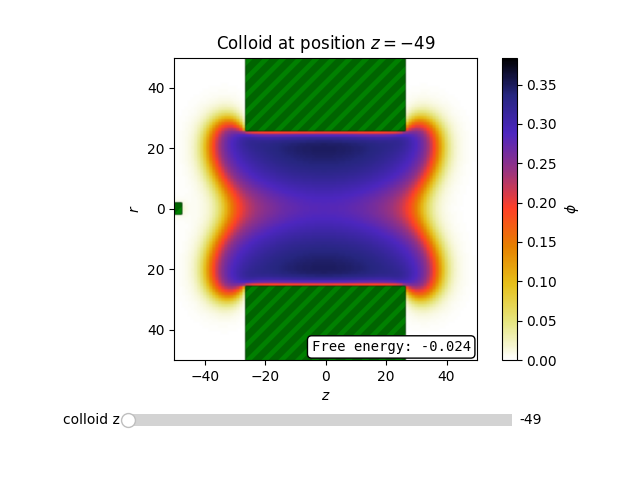

In [12]:
# ----------------------------------------------------------------------
# Interactive exploration of precomputed SF-SCF results
# ----------------------------------------------------------------------
# Dropdown: select parameter set (χ_PS, χ_PC, colloid diameter)
# Slider:   move colloid along z-axis
# Output:   perturbed polymer density and insertion free energy
# ----------------------------------------------------------------------

from src.make_plot import interactive_plot_phi

interactive_plot_phi(
    precomputed_SCF_results,
    fix_clim=True,
    walls=walls,
    rlim=(-50, 50),
    zlim=(-50, 50),
)



## Surface and volume projection matrices for cylindrical particles

Following Supplementary Note 4, the analytical calculation of $\Delta F_{\text{cyl}}$ requires **surface** and **volume** projection matrices.

While the colloid with diameter $d=4$ was used for fitting, it is instructive to also plot these matrices for larger particles, since they are needed when evaluating $\Delta F_{\text{cyl}}$ with the fitted model for different sizes.

Cylindrical particle volume projection matrix:
[[3.14159265 3.14159265 3.14159265 3.14159265]
 [9.42477796 9.42477796 9.42477796 9.42477796]]

Cylindrical particle surface projection matrix:
[[ 3.14159265  0.          0.          3.14159265]
 [21.99114858 12.56637061 12.56637061 21.99114858]]


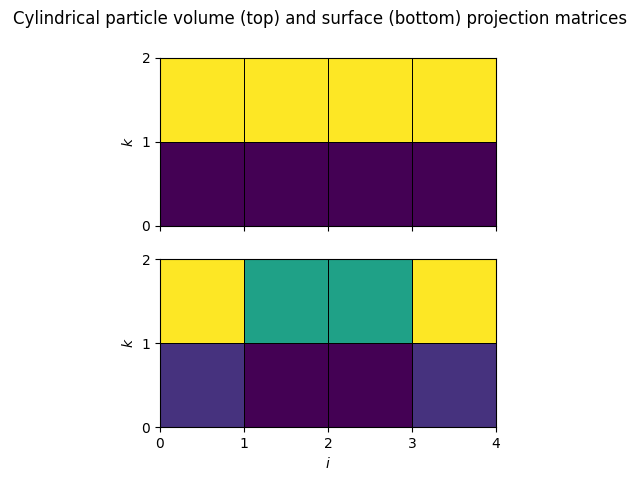

In [13]:
import numpy as np
from src.make_plot import plot_volume_and_surface_matrices_cylinder

# ----------------------------------------------------------------------
# Generate surface and volume projection matrices for a cylinder
# ----------------------------------------------------------------------
def cylinder_projection_matrices(radius: int, height: int = None):
    """
    Construct volume and surface projection matrices for a cylinder 
    of given radius and height coaxial to z-axis.

    Parameters
    ----------
    radius : int
        Cylinder radius (in lattice units).
    height : int, optional
        Cylinder height (defaults to diameter = 2*radius).

    Returns
    -------
    volume : ndarray
        Volume projection matrix.
    surface : ndarray
        Surface projection matrix.
    """
    if height is None:
        height = radius * 2

    r = np.arange(radius)
    volume_r = np.pi * (2 * r + 1)
    volume = np.tile(volume_r, (height, 1)).T
    surface = np.zeros_like(volume)

    # Top and bottom surfaces
    surface[:, 0] = surface[:, -1] = volume_r
    # Curved surface contribution
    surface[-1, :] += 2 * np.pi * radius

    return volume, surface


# Example: colloid with diameter d=4
COLLOID_DIAMETER = 4
volume, surface = cylinder_projection_matrices(COLLOID_DIAMETER // 2, COLLOID_DIAMETER)

plot_volume_and_surface_matrices_cylinder(volume, surface)


## Analytical model for insertion free energy of cylindrical colloids

Following the original work (Supplementary Note 4), we build an analytical estimate of the insertion free energy $\Delta F_{\text{cyl}}$.

- The **interfacial term** is obtained from a local surface coefficient  
  $\gamma(\chi_{\text{PS}}, \chi_{\text{PC}}, \phi; X)$ - `gamma_model(chi_PS, chi_PC, phi, X)`,  
  where $X = (b_0,b_1)$ are phenomenological parameters.  
  Together with the surface projection matrix from `cylinder_projection_matrices`, this gives the interfacial free energy.

- The **osmotic term** is derived from the local osmotic pressure  
  $\Pi(\phi,\chi_{\text{PS}})$ - `Pi(phi, chi_PS)` and the corresponding volume matrix from `cylinder_projection_matrices`.

The total analytical free energy is implemented in `insertion_free_energy_cylinder`.

### Constructing the cost function

To determine the fitting parameters $b_0$ and $b_1$, we compare analytical predictions with SF-SCF results:

1. For each dataset characterized by $(\chi_{\text{PS}}, \chi_{\text{PC}}, d)$,  
   the unperturbed polymer profile $\phi\{\chi_{\text{PS}}\}(r,z)$ is taken from empty-pore simulations.

2. Using this profile, we compute $\Delta F_{\text{cyl}}(b_0,b_1)$ with the analytical model.

3. At every colloid position $z_c$, we calculate the **residual**
   $$
   r(z_c) \;=\; \Delta F_{\text{SF-SCF}}(z_c) - \Delta F_{\text{cyl}}(z_c; b_0,b_1).
   $$

4. All residuals are collected into a single vector across all datasets.

The **cost function** is then defined as the sum of squared residuals:
$$
\sum_{z_c,\,\chi_{\text{PC}},\,d}
\bigl[ \Delta F_{\text{SF-SCF}}(z_c) - \Delta F_{\text{cyl}}(z_c; b_0,b_1) \bigr]^2.
$$

We minimize this cost function using `scipy.optimize.least_squares` to obtain the fitted values of $b_0$ and $b_1$.


In [14]:
import numpy as np
from scipy.optimize import least_squares

# ----------------------------------------------------------------------
# Surface coefficient model
# ----------------------------------------------------------------------
def gamma_model(chi_PS, chi_PC, phi, X):
    """
    Local surface coefficient γ_model.

    Parameters
    ----------
    chi_PS : float
        Polymer-solvent interaction parameter.
    chi_PC : float
        Polymer-colloid interaction parameter.
    phi : ndarray
        Polymer volume fraction profile.
    X : tuple/list (b0, b1)
        Fitting parameters.

    Returns
    -------
    gamma : ndarray
        Local surface coefficient field.
    """
    b0, b1 = X
    chi_crit = 6 * np.log(5/6)
    phi_corr = (b0 + b1 * chi_PC) * phi
    chi_ads = chi_PC - chi_PS * (1 - phi_corr)
    gamma = (chi_ads - chi_crit) * phi_corr / 6
    return gamma


# ----------------------------------------------------------------------
# Osmotic pressure
# ----------------------------------------------------------------------
def Pi(phi, chi_PS):
    """Flory-Huggins osmotic pressure."""
    return -np.log(1 - phi) - phi - chi_PS * phi**2


# ----------------------------------------------------------------------
# Analytical insertion free energy for cylindrical colloid
# ----------------------------------------------------------------------
def insertion_free_energy_cylinder(radius, phi_0, chi_PS, chi_PC, gamma_model, X_args):
    """
    Compute insertion free energy ΔF_cyl from osmotic and interfacial terms.
    """
    from scipy.signal import convolve
    volume, surface = cylinder_projection_matrices(radius)

    # Pad to match projection kernel
    phi_0 = np.pad(phi_0[0:radius], ((0, 0), (radius, radius - 1)))

    Pi_arr = Pi(phi_0, chi_PS)
    gamma_arr = gamma_model(chi_PS, chi_PC, phi_0, X_args)

    osmotic = convolve(Pi_arr, volume, "valid")[0]
    interfacial = convolve(gamma_arr, surface, "valid")[0]
    return osmotic + interfacial


# ----------------------------------------------------------------------
# Cost function builder for fitting b0, b1
# ----------------------------------------------------------------------
def create_cost_function(SCF_results, SCF_results_empty, gamma_model):
    """
    Build cost function comparing SF-SCF results with analytical model.
    """
    def cost_function(X):
        cost = np.array([])
        for (chi_PS, chi_PC, diameter), group in SCF_results.groupby(
            by=["chi_PS", "chi_PC", "colloid_diameter"]
        ):
            # Retrieve unperturbed polymer profile for this chi_PS
            phi_empty = SCF_results_empty.loc[
                SCF_results_empty.chi_PS == chi_PS, "phi"
            ].squeeze()

            FE = insertion_free_energy_cylinder(
                diameter // 2, phi_empty, chi_PS, chi_PC, gamma_model, X
            )

            # Residuals between SCF data and analytical estimate
            residuals = group.apply(
                lambda row: row.free_energy - FE[int(row.colloid_position + len(FE)//2)],
                axis=1,
            )
            cost = np.concatenate([cost, residuals.to_numpy()])
        return cost

    return cost_function


# ----------------------------------------------------------------------
# Fit parameters b0, b1
# ----------------------------------------------------------------------
X0 = [1, 0]  # initial guess
cost_function = create_cost_function(
    precomputed_SCF_results,
    pd.DataFrame([SCF_empty_pore_result]),  # empty pore reference profiles
    gamma_model=gamma_model,
)
b0, b1 = map(float, least_squares(cost_function, X0).x)

print(f"{b0=}, {b1=}")


b0=0.6993128436449816, b1=-0.32881190826589896


### Validation of the fit

Details of the fit validation are discussed in Supplementary Note 4 (Figures S5-S6).  
Here we revisit the insertion free energy profile for the selected case  
$\chi_{\text{PC}} = 0$, $\chi_{\text{PS}} = 0.6$, and colloid diameter $d = 6$.

As in Figure S5, we compare the analytical model with fitted parameters $(b_0,b_1)$  
against the non-fitted case $(b_0=1, b_1=0)$, which ignores polymer depletion/enrichment effects.


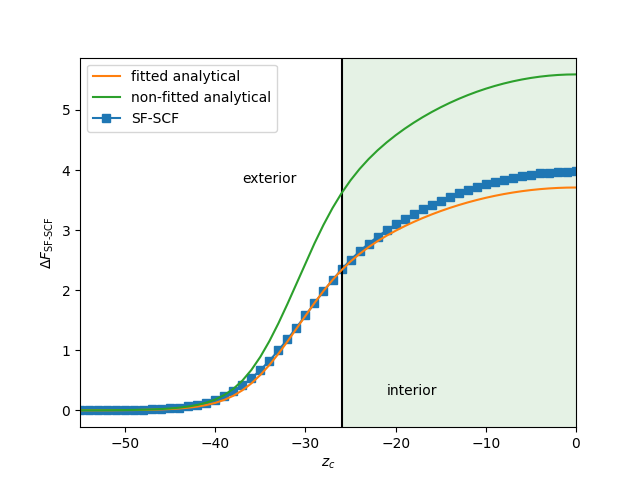

In [24]:
# --------------------------------------------------------------------------------
# Validation of the analytical fit against SF-SCF data
# --------------------------------------------------------------------------------

# Plot SF-SCF insertion free energy profile
fig, ax = plot_insertion_free_energy(SCF_results, pore_length=52, show_ground_state=False)
# fig, ax = plot_insertion_free_energy(
#     precomputed_SCF_results, 
#     pore_length=52, 
#     show_ground_state=False,
#     chi_PC = 0,
#     colloid_diameter = 6,
#     )

# Analytical insertion free energy using fitted parameters (b0, b1)
analytical_fe = insertion_free_energy_cylinder(
    radius=6 // 2,
    phi_0=phi_0,
    chi_PS=0.6,
    chi_PC=0,
    gamma_model=gamma_model,
    X_args=(b0, b1),
    # Alternative: X_args=(0.7, -0.3)  # values reported in the original work
)

# Analytical insertion free energy using default (non-fitted) parameters
analytical_fe_nofit = insertion_free_energy_cylinder(
    radius=6 // 2,
    phi_0=phi_0,
    chi_PS=0.6,
    chi_PC=0,
    gamma_model=gamma_model,
    X_args=(1, 0),
)

# Axial positions (centered around zero)
z = np.arange(len(analytical_fe)) - len(analytical_fe) // 2

# Overlay analytical results on the SF-SCF curve
ax.plot(z, analytical_fe, label="fitted analytical")
ax.plot(z, analytical_fe_nofit, label="non-fitted analytical")

# Dummy plot entry to preserve SF-SCF legend label
ax.plot([], [], color="tab:blue", marker="s", label="SF-SCF")

ax.set_xlim(-55, 0)

ax.legend()
